# Eveluation and further visulizatoin
of the optimized models (lr, SVC, RF)

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Prepare data

In [2]:
from split import my_train_test_split

data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_1'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(y, groups)
X_test = X[test_idx]
y_test = y[test_idx]

In [3]:
X_test.shape

(22096, 24)

In [4]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

# Predict the test set

In [5]:
from joblib import load
lr = load('models/roll_lr_model_ss_20201113.joblib')
svc = load('models/roll_svc_model_ss_20201113.joblib')
rf = load('models/roll_rf_model_ss_20201116.joblib')

In [76]:
y_df = pd.DataFrame(y_test, columns=['y'])
for col, model in zip(['y_lr', 'y_svc', 'y_rf'], [lr, svc, rf]):
    y_df[col] = model.predict(X_test)

In [9]:
y_df

,y,y_lr,y_svc,y_rf
0,1,2,2,1
1,1,2,2,1
2,1,2,2,1
3,1,2,2,1
4,1,2,2,1
...,...,...,...,...
22091,6,6,6,6
22092,6,6,6,6
22093,6,6,6,6
22094,6,6,6,6


# Evaluation

## Balanced score

In [91]:
from sklearn.metrics import balanced_accuracy_score as score
for col in ['y_lr', 'y_svc', 'y_rf']:
    print('Balanced score of {}: {:.2f}'.format(col, score(y_true=y_df.y, y_pred=y_df[col])))

Balanced score of y_lr: 0.57
Balanced score of y_svc: 0.60
Balanced score of y_rf: 0.48


## Recall matrix
It is modified from confusion matrix, disigned to evaluate the accuracy of a classification. The confusion matrix is first computed. Then the numbers (counts) are normalized by the sum of each row (i.e., sum of true positive and false negative). The ratios in diagonal represent recall in percent. This give us the view of "how many data points in percent described as facies A by sedimentologists are recognized correctly as A and falsely as other facies by models. The accuracy in xlabel is the balanced score.

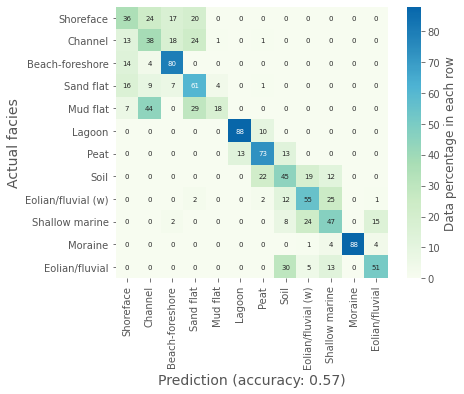

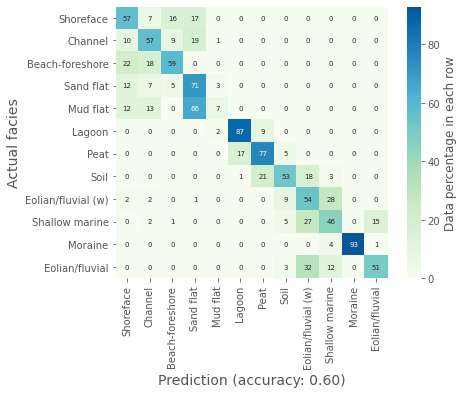

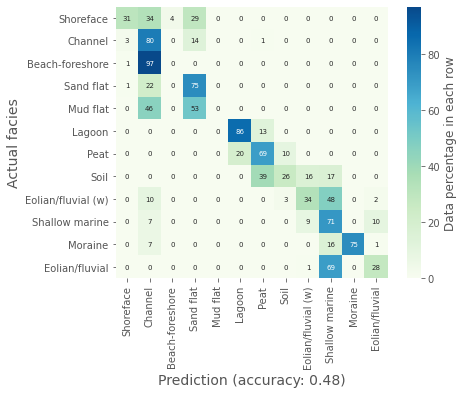

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score as score

for col in ['y_lr', 'y_svc', 'y_rf']:
    # make confusion matrix between prediction and actual labels
    confusion = confusion_matrix(y_df.y, y_df[col])
    model_name = col[2:]
    con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
    #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

    # normalize the counts ineach row and present in percent
    x = np.copy(confusion).astype(float)
    x /= x.sum(axis = 1, keepdims = True)
    con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
    #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

    # Plot the matrix
    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
    sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, center = 50,
                xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
               )
    
    ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=y_df.y, y_pred=y_df[col])), size = 14)
    ax.set_ylabel('Actual facies', size = 14)
    fig.savefig('results/roll_recall_%_{}_{}.png'.format(model_name, date))

The models all behave very bad predictions on mud flat, which they sholdn't because it's a rather homogenious facies. <br>
Except for the mud flat, the models are having different performances in different facies. RF's model has generally worse accuracy than the other models. It espacially happens to beach-foreshore and Eolian/fluvial. There is almost no beach-foreshore predicted by rf's model.<br>

## Let's check about this mud flat problem

In [81]:
y_df['composite_id'] = data_df.composite_id.values[test_idx]
y_df.set_index('composite_id', inplace=True)
y_df = pd.concat([pd.read_csv('data/info.cleaned.all.csv', index_col=0, usecols=['composite_id', 'composite_depth_mm', 'section_depth_mm', 'core_id', 'core_section']), y_df], 
                   axis=1, join='inner') 

In [82]:
y_df

,composite_depth_mm,core_id,core_section,section_depth_mm,y,y_lr,y_svc,y_rf
composite_id,,,,,,,,
N12_00052,52,N12,N12-4,102.0,1,0,0,1
N12_00054,54,N12,N12-4,104.0,1,0,0,1
N12_00056,56,N12,N12-4,106.0,1,0,0,1
N12_00058,58,N12,N12-4,108.0,1,0,0,1
N12_00060,60,N12,N12-4,110.0,1,0,0,1
...,...,...,...,...,...,...,...,...
W5_02133,2133,W5,W5-1,2133.0,6,6,6,6
W5_02135,2135,W5,W5-1,2135.0,6,6,6,6
W5_02137,2137,W5,W5-1,2137.0,6,6,6,6


In [83]:
y_df[y_df.y==4]

,composite_depth_mm,core_id,core_section,section_depth_mm,y,y_lr,y_svc,y_rf
composite_id,,,,,,,,
N47_00027,27,N47,N47-5,47.0,4,3,3,1
N47_00029,29,N47,N47-5,49.0,4,1,3,1
N47_00031,31,N47,N47-5,51.0,4,1,3,1
N47_00033,33,N47,N47-5,53.0,4,1,3,3
N47_00035,35,N47,N47-5,55.0,4,1,3,1
...,...,...,...,...,...,...,...,...
N47_00385,385,N47,N47-5,405.0,4,3,3,1
N47_00387,387,N47,N47-5,407.0,4,3,3,1
N47_00389,389,N47,N47-5,409.0,4,3,3,3


In [84]:
def plot_facies(data_df, core, y_preds, Facies):
    """
    data_df is the dataframe having info and labels.
    core is the string of the core you want to plot.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    """
    X = data_df[data_df.core_id == core]
    plt.figure(figsize = (3.54, 7.25))
    plt.scatter(X.y - .2, X.composite_depth_mm, marker = 's', s = 1, lw = .5, label = 'description')
    for i, y_pred in enumerate(y_preds):
        plt.scatter(X[y_pred] + .15*i, X.composite_depth_mm, marker = 's', s = 1, lw = .5, label = y_pred)
    plt.ylim(X.composite_depth_mm.max() + 20, 0)
    plt.ylabel('Composite depth (mm)')
    plt.xticks(np.unique(data_df.y), Facies, rotation = 90)
    plt.legend(markerscale=3, title=core)

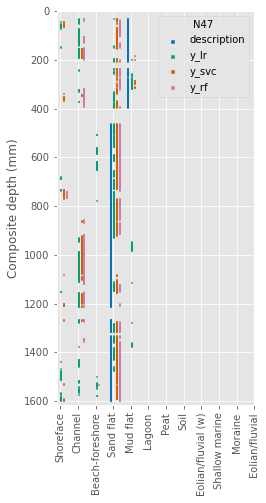

In [85]:
plot_facies(y_df, 'N47', ['y_lr', 'y_svc', 'y_rf'], Facies)

There are only the data points from the top of N47 belonging to mud flat in the test set. Mostly, they are classified as sand flat or channel by models. Based on the raw lothology descroption, they were actually described as mixed and sand flat. First, Dirk and I decided to change the labels to mixed flat only. Latter due to the simplification of labels, these points were changed from mixed flat to mud flat by me. I would say, it's better to change them to sand flat since the grain size is actually fine sand based on the description. This modification will lead to redo the workflows again since they are the only data points of mud flat in the test set...

## Conjunction matrix
It displays how the facies changes along the core. 

In [86]:
def detect_conjuction(data_df, y_preds, Facies):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 3:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/roll_conjunction_matrix_{}_{}.png'.format(model_name, date))
    
    return mat_dict

There are 28 boundaries in description.
There are 1348 boundaries in the optimized lr model's predictions.
There are 1284 boundaries in the optimized svc model's predictions.
There are 742 boundaries in the optimized rf model's predictions.


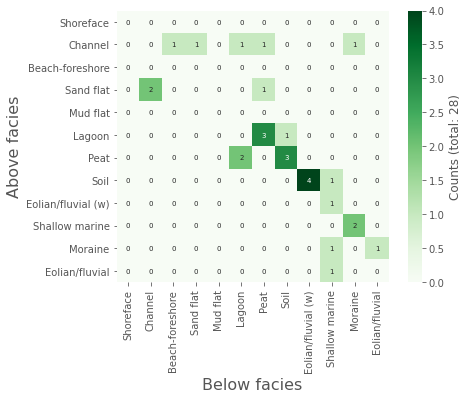

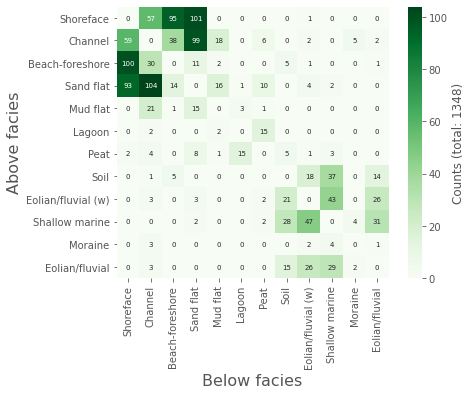

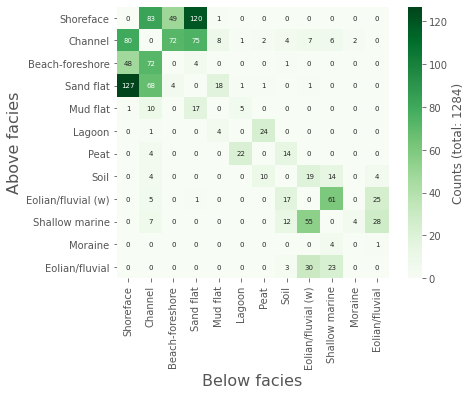

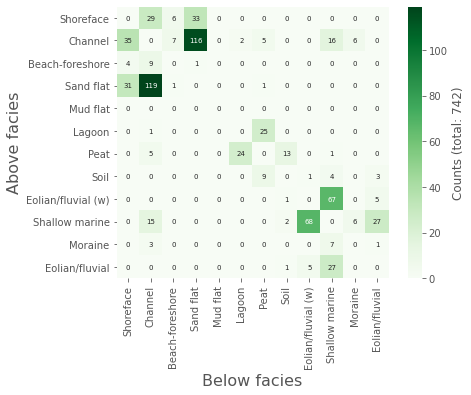

In [87]:
mat_dict = detect_conjuction(y_df,  ['y', 'y_lr', 'y_svc', 'y_rf'], Facies)

Aparently, those models all have too many facie changes. This makes the facies distribution fragmented. Although RF provides less fragmented predictions, it still has too many facies changes comparing to the sedimentologists' description.

# Let's thoroughly check the predictions in the test set
Just double check.

In [92]:
np.unique(y_df.core_id)

array(['N12', 'N14', 'N15', 'N16', 'N17', 'N18', 'N23', 'N24B', 'N25',
       'N28', 'N35', 'N36', 'N39', 'N40', 'N42', 'N43', 'N44', 'N47',
       'N53', 'N54B', 'N59', 'N66', 'N69', 'N70', 'N72', 'N73', 'N77',
       'N78', 'N84', 'N85', 'N97', 'VVC02', 'VVC04', 'VVC09', 'VVC12',
       'VVC14', 'VVC16', 'VVC19', 'VVC20', 'VVC22', 'W5'], dtype=object)

In [94]:
# stop display figures inline
%matplotlib auto

In [45]:
def plot_facies(data_df, core, y_preds, Facies):
    """
    data_df is the dataframe having info and labels.
    core is the string of the core you want to plot.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    """
    X = data_df[data_df.core_id == core]
    plt.figure(figsize = (3.54, 7.25))
    plt.scatter(X.y - .2, X.composite_depth_mm, marker = 's', s = 1, lw = .5, label = 'description')
    for i, y_pred in enumerate(y_preds):
        plt.scatter(X[y_pred] + .15*i, X.composite_depth_mm, marker = 's', s = 1, lw = .5, label = y_pred)
    plt.ylim(X.composite_depth_mm.max() + 20, 0)
    plt.ylabel('Composite depth (mm)')
    plt.xticks(np.unique(data_df.y), Facies, rotation = 90)
    plt.legend(markerscale=3, title=core)
    plt.savefig('results/roll_test_ys_{}_{}.png'.format(core, date))

In [47]:
for core in np.unique(y_df.core_id):
    plot_facies(y_df, core, ['y_lr', 'y_svc', 'y_rf'], Facies)

/home/users/aslee/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


N12: most of models' predictions have fragmented issue, but those of rf model behave okay. The channel fill deposits are mostly miss recognized as beach-foreshore in rf model.<br>
N14: most predictions are good. only rf makes wrong predictions.<br>
N15: most predictions are good, just a bit fragmented. rf's predictions are less fragmented.<br>
N16: most predictions of shallow marine are wrong. lr's predictions are more fragmented, whicle rf's act fine.<br>
N17: lr's predictions of channel are mostly wrong. They are recognized as beach-foreshore by lr.<br>
....<br>
The core-by-core observations of those predictions don't really show any characteristic that the recall and conjuction matrices don't show.

# Summary
The prediction accuracies of the optimized models are not good enough and have different behaviors. In common, the facies distribution are all too fragmented comparing to the sedimentologists's description. The labels of mud flat need to be changed, leading to a redo of the training workflow. I'll redo it to at least solve the mud flat issue. The fragmentic characteristic might be solved by another way of combining neighbor information, such as defining sample blocks (an array of sample points as one new sample point). But solving the poor accuracy is not so promising. Probably, I can only make a thorough discussion out of all approaches in my second paper.